In [ ]:
*** IMPORTANT Prerequisite ***
"""
This practical uses resting state fMRI data from Human Connectome Project (HCP). 
Before you continue, we strongly recommend that you create an account and sign the agreement here:
https://db.humanconnectome.org/app/template/Login.vm
"""

*** Introduction ***
"""
Probabilistic Functional Modes (or PFMs) provide an alternative to group-ICA (FSL MELODIC) followed by 
Dual-Regression (DR) for estimating resting state networks (RSNs) in population and individuals. 

A key difference between the two models is that in the ICA-DR paradigm, we first concatenate data across many 
subjects and estimate RSNs at the group-level. We then run Dual-Regression to estimate subject-specific networks
using an ad-hoc approach. 

In contrast, PFM framework models the population and every individual simultaneously. For this purpose, as 
illustrated in the Figure below, hierarchical Bayesian links between group-level and subject-level networks 
allow for bidirectional flow of information between the two. 

Similar to ICA-DR paradigm, probabilistic functional modes (i.e., brain networks) are summarised in terms of how 
they are spatially configured across the brain voxels (i.e., "topographies") and a timecourse that captures a 
network's activity over time. Temporal correlation between network timecourses is referred to as 
"functional connectivity", and each network is additionally described in terms of its "amplitude" or the 
strength of its timecourse activity.
From now on, we will refer to:
Topographies -> Spatial Maps (SMAPs), or simply Maps 
Temporal Connectivity -> NetMats

Note: In this practical, some of the cells are executable, those are marked with #Executable_cell! 
When you see this hashtag, please press the "Run" button above.  

Our aim is to: 
1- Look at group-level PFMs and compare them with group-ICA networks
2- Look at subject-level PFMs and compare them with dual regression networks

"""

                    *** The overall architecture of PFM framework (arrows -> Bayesian links) *** 



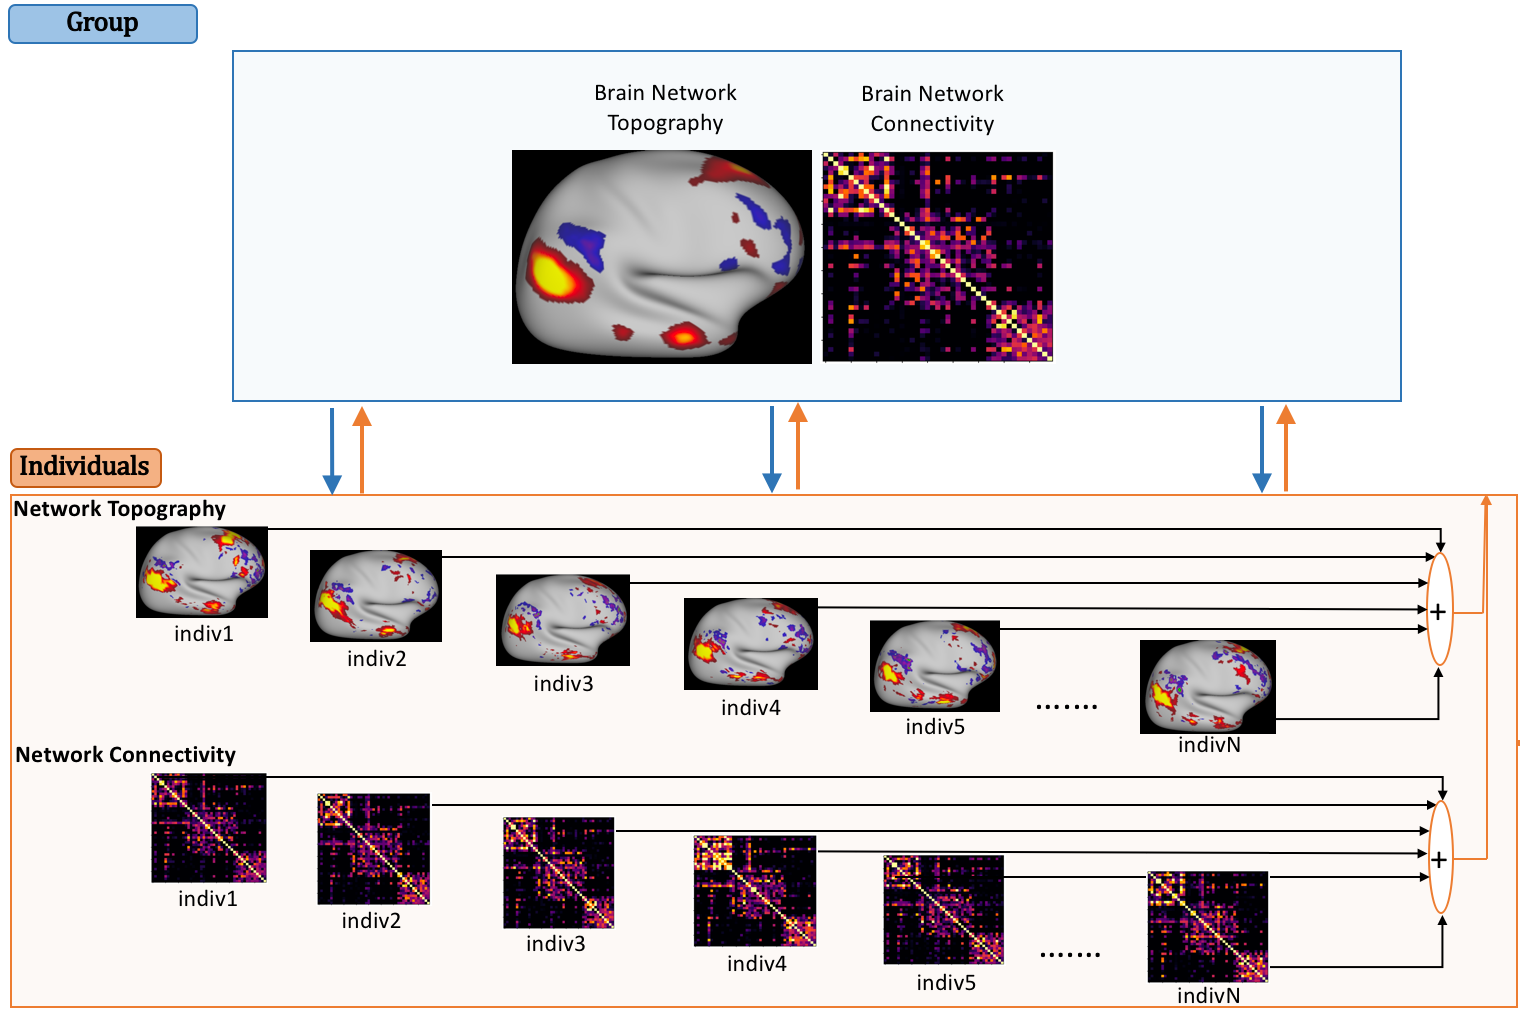

In [1]:
#Executable_cell! press Run to see the architecture of PFM framework

from pathlib import Path
homedir = str(Path.home())

print("                    *** The overall architecture of PFM framework (arrows -> Bayesian links) *** \n")
from IPython.display import Image
Image(filename=homedir+"/fsl_course_data/PFM/PFMs.png")

In [ ]:
*** Preprocessing ***

"""
Preprocessing steps that PFMs need are similar to the steps you followed in group-ICA practical.
Data used here are cleaned using unaggressive temporal highpass filtering,
single-subject ICA followed by FSL-FIX, and non-linearly registered to a standard 2mm MNI space (using FSL-FNIRT).

Additionally, in order to enhance PFMs' single subject estimations, we have applied an additional ~5mm FWHM 
spatial smoothing using 'fslmaths -s'. This is strongly recommended for PFMs!

"""

In [ ]:
*** Running the model ***

"""
PFMs are currently available via two implementations, PROFUMO for smaller data sizes, and 
stochastic PROFUMO (sPROFUMO) for big data. Both models use the same command line but with different flags. 
For data presented in this practical, we have applied sPROFUMO to 1003 subjects in HCP. 4 of these subjects
are included in this practical (anonymised).

This can be obtained by running the following command in the terminal 
(don't run this, it will take too long for this practical!): 
  
"""
n_pfms=50

/path/to/installation/PROFUMO path/to/data/location/DataLocations.json $n_pfms \
/vols/Scratch/rezvanh/fsl_course_data/PFM/data/PFM_output.pfm --bigData --stochasticBatchSize 50 \
-m /vols/Scratch/rezvanh/fsl_course_data/PFM/data/mask.nii.gz \
--useHRF 0.72 --hrfFile /vols/Scratch/rezvanh/fsl_course_data/PFM/HRFs/DefaultHRF.phrf -d 0.075 > /vols/Scratch/rezvanh/fsl_course_data/PFM/data/output_log.txt

"""
The main file that you need to prepare for running the model is DataLocations.json file.
Inside this file, there is a nested python dictionary with subject and runs as keys, and datapaths as values.
An example can be found in /vols/Scratch/rezvanh/fsl_course_data/PFM/data/PFM_output.pfm/DataLocations.json. 

For a full list of input arguments and their explanations see:
/vols/Scratch/rezvanh/fsl_course_data/PFM/PFM_arguments.txt

Here, we will look at model outputs.
"""


In [ ]:
*** post-processing ***
"""
After you run the model, you can use our automated post-processing pipeline to summarise the results.
However, in this practical, for educational purposes, we will use python API.
"""


In [2]:
#Executable_cell! press Run.

"""
0 IMPORT SOME USEFUL PACKAGES
LOADING PFMs AND SOME GENERAL VARIABLES
"""

"""
The profumo Python package provides a flexible way of extracting
information from an analysis. Almost all the parameters inferred as part of the
model, as well as the preprocessing parameters, are available via the
profumo.PFMs class. Let's import this package and some other useful packages.
"""

#import some general python packages that we will need 
import sys, numpy, copy
import matplotlib.pyplot as plt
import nibabel#external python package for handling NIFTI images

#import profumo package  and a few profumo modules that we will use
sys.path.append( homedir+"/fsl_course_data/PFM/Python" )
import profumo
from profumo import utilities
from profumo import plotting
import profumo.questions as questions

#load the relevant brain mask, this is to help save data in NIFTI format
mask_name=homedir+"/fsl_course_data/PFM/data/mask.nii.gz"
mask_image=nibabel.load(mask_name)
mask_inds=profumo.io.load_mask(homedir+"/fsl_course_data/PFM/data/mask.nii.gz")

#The output of running PFMs is saved in PFM_output.pfm directory
pfm_dir=homedir+"/fsl_course_data/PFM/data/PFM_output.pfm"
#'pfms' variable obtained from PFM class includes all of the necessary functions and matrices from model output
pfms = profumo.PFMs( pfm_dir, mask_filename=mask_name )

#set some general variables:
#subject names
subject_names=pfms.subjects#4 subjects included in the directory: ['subj_0','subj_1','subj_2','subj_3']
#run (session) names
session_names=pfms.runs[subject_names[0]]#HCP data includes 4 sessions per subject: ['R1_LR','R1_RL','R2_LR','R2_RL']

#some summaries of data properties
nmodes=pfms.M #we have estimate 50 probabilistic functional modes (PFMs) or simply 'modes' 
ntimes=1200
nsubjs=pfms.S #we have 4 subjs
nsess=len(session_names)#we have 4 sessions
TR=pfms.config['HRF parameters']['TR (s)']#fMRI repetition time (i.e. TR) is 0.72 for HCP

#extra step: load pre-computed PFM order to match ICA results (more in the next sections)
pfmorder=numpy.load(homedir+"/fsl_course_data/PFM/data/PFM_order.npy")


Initialising PFM results...
PFM directory: /Users/rezvanh/fsl_course_data/PFM/data/PFM_output.pfm
Parsing config file...
Parsing data locations file...
Generating subject lists...
4 subjects identified, verifying directories...
Generating run lists...
16 runs identified, verifying directories...
Done.



In [ ]:
**************************************
*** 1 - group results ***
**************************************
Next sections focus on group-level results

In [3]:
#Executable_cell! press Run.

"""
1.1 GROUP-LEVEL SPATIAL MAPS
"""

"""

"""

#load group-level PFMs (this is within a brain mask, so no scalp skull etc. voxels)
PFM_group_smap=pfms.load_group_maps()
PFM_group_smap=PFM_group_smap[:,pfmorder]


#save group maps as a NIFTI image
PFM_group_name=homedir+"/fsl_course_data/PFM/data/PFM_groupmaps_sorted"
profumo.io.save_image(PFM_group_name,PFM_group_smap,mask_image,mask_inds=mask_inds)



Loading group maps...
Done.



In [ ]:
"""
1.2 Visualising results in FSLeyes - bring up a terminal window!
"""

"""
Run below command in the terminal to open group-level PFMs (that you just saved) and group-level MELODIC ICs 
(that we have provided) in FSLeyes. The RSNs are ordered to match each other spatially.

Make sure that the two images are 'linked'. Now go to the ‘View’ menu at the top and add a second 
ortho view, so we can look at the PFM and MELODIC images side-by-side. 
Next, make sure that the window on the left is showing the PFM results 
(by clicking the toggle button next to PFM_50), 
and that the window on the right is showing the MELODIC results 
(by clicking the toggle button next to ICA_50).

Look at RSNs 1 to 5 from PFM and MELODIC. These are generally well-matched, can you spot any differences?

Now go to PFM 40, can you name this network? What about MELODIC 40? 
"""
$FSLDIR/bin/fsleyes -std /vols/Scratch/rezvanh/fsl_course_data/PFM/data/PFM_groupmaps_sorted.nii.gz --displayRange 0.5 4 \
--name PFM_50 --cmap red-yellow --negativeCmap blue-lightblue \
/vols/Scratch/rezvanh/fsl_course_data/PFM/data/melodic_IC_sorted.nii.gz --displayRange 15 90 -n ICA_50 --cmap red-yellow \
--negativeCmap blue-lightblue --useNegativeCmap \



In [4]:
#Executable_cell! Please press Run and answer the question.
questions.question1()

As we go to higher dimensions do you expect PFMs to: 
 A) Split the networks, similar to ICA.  
 B) Do not split the networks. [A/B]? : B
Correct! let's tackle this in the next sections


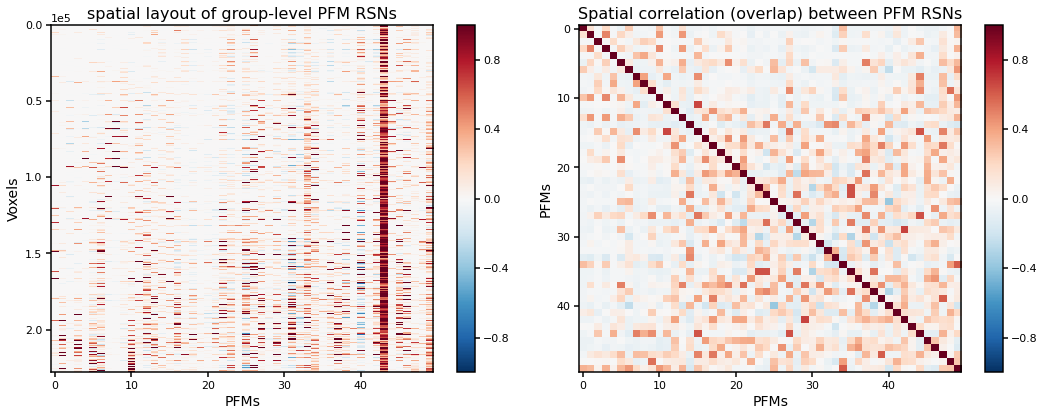

In [5]:
#Executable_cell! 

"""
1.3 PFMs GROUP-LEVEL SPATIAL MAP CORRELATIONS

Now let's check how PFM spatial maps relate to each other. Specifically, are they spatially overlapping?
"""

fig,(ax1,ax2)=plt.subplots(1,2)
fig.set_size_inches(15, 6, forward=True)
plotting.plot_matrix(fig,ax1,PFM_group_smap,vmin=-1,vmax=1,cmap='RdBu_r',xlabel='PFMs',ylabel='Voxels')
ax1.set_title('spatial layout of group-level PFM RSNs')

#estimate spatial overlap between group-level PFM RSNs 
R_pfm=numpy.corrcoef(PFM_group_smap,rowvar=False)

plotting.plot_matrix(fig,ax2,R_pfm,vmin=-1,vmax=1,cmap='RdBu_r',xlabel='PFMs',ylabel='PFMs')
ax2.set_title('Spatial correlation (overlap) between PFM RSNs'),plt.show();

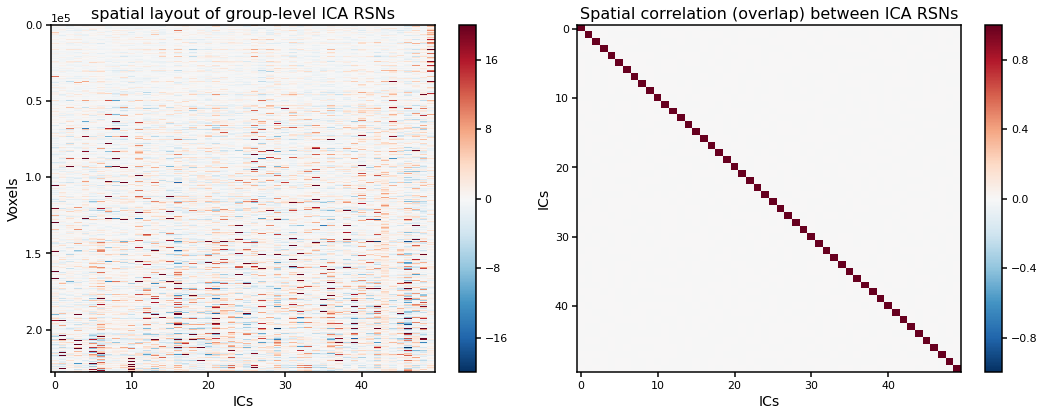

In [6]:
#Executable_cell! 
"""
1.4 ICA (MELODIC) Group-level Spatial Maps
"""
from profumo.io import unwrapNIFTI

#load group-level ICA RSNs (within brain mask)  
ICA_group_name=homedir+"/fsl_course_data/PFM/data/melodic_IC_sorted.nii.gz"
ICA_group_smap=unwrapNIFTI(mask_name, ICA_group_name) #load ICA groupmaps, inside a brain mask

# R=numpy.corrcoef(PFM_group_smap,ICA_group_smap,rowvar=False)  #compute spatial correspondence 

# fig,ax=plt.subplots(); plotting.plot_matrix(fig,ax,R[nmodes:,:][:,nmodes:],vmin=-1,vmax=1,cmap='RdBu_r',xlabel='ICs',ylabel='ICs')
# ax.set_title('Spatial correlation (overlap) between ICA RSNs:'),plt.show();


fig,(ax1,ax2)=plt.subplots(1,2)
fig.set_size_inches(15, 6, forward=True)
plotting.plot_matrix(fig,ax1,ICA_group_smap,vmin=-20,vmax=20,cmap='RdBu_r',xlabel='ICs',ylabel='Voxels')
ax1.set_title('spatial layout of group-level ICA RSNs')

#estimate spatial overlap between group-level PFM RSNs 
R_ica=numpy.corrcoef(ICA_group_smap,rowvar=False)  #compute spatial correspondence 

plotting.plot_matrix(fig,ax2,R_ica,vmin=-1,vmax=1,cmap='RdBu_r',xlabel='ICs',ylabel='ICs')
ax2.set_title('Spatial correlation (overlap) between ICA RSNs'),plt.show();


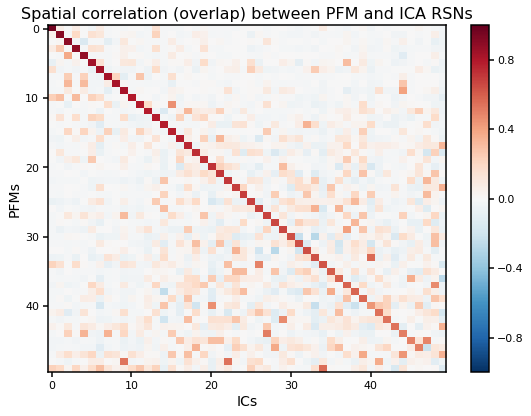

In [7]:
#Executable_cell! 
"""
1.5 Comparing PFMs Group-level Spatial Maps and ICA (MELODIC) Group-level Spatial Maps
"""
R=numpy.corrcoef(PFM_group_smap,ICA_group_smap,rowvar=False)  #compute spatial correspondence 


fig,ax=plt.subplots(); plotting.plot_matrix(fig,ax,R[:nmodes,:][:,nmodes:],vmin=-1,vmax=1,cmap='RdBu_r',xlabel='ICs',ylabel='PFMs')
ax.set_title('Spatial correlation (overlap) between PFM and ICA RSNs'),plt.show();

In [8]:
#Executable_cell! Please press Run and answer the question.
questions.question2()

Based on above figures and what you examined in FSLeyes, 
 describe one similarity and two differences between PFM and ICs at 50-RSN decomposition and discuss with your tutor. 
 Press enter to see the answers 
 
Similarity: RSNs ~1-35 are well matched 

Difference 1: ICA modes are spatially non-overlapping. discuss with tutor why? 

Difference 2: RSNs ~35-50 are not well-matched. can you spot a key way of difference (hint: splitting)? 



Loading group-level temporal precision matrices...
Done.

                             ***Group-level Partial temporal correlation (NetMat)*** 



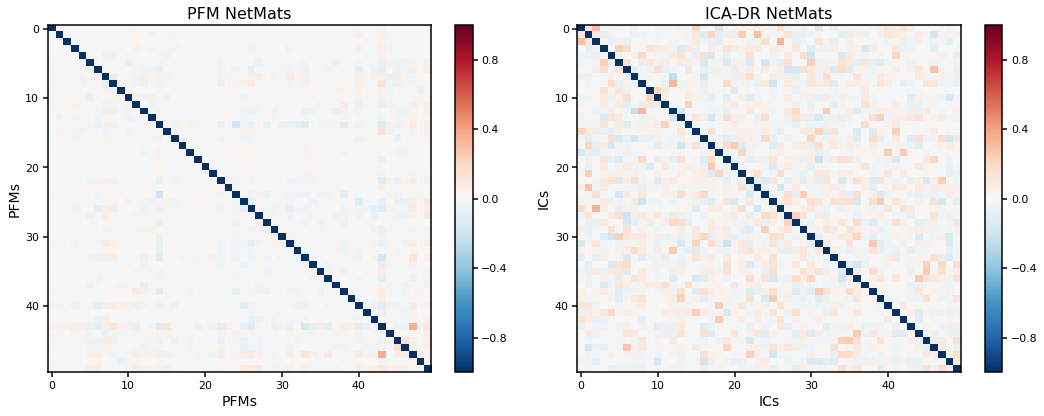

In [9]:
#Executable_cell!

"""
1.6 GROUP-LEVEL TEMPROAL NETMATS
"""
"""
So far, we have looked at group-level spatial maps. Now let's look at temporal connectivity or network matrices 
(NetMats). These are similar to what you learned in FSLnets practical.

If you scroll up to the first figure (the architecture of PFM framework), we show that both spatial maps and 
temporal NetMats are simultaneously estimated for the group and individuals. Therefore, here we only need to 
load the group-level PFM NetMats and examine them, there is no need to recalculate them based on time courses.
Note that in this practical we only examine NetMats based on "partial" correlations.

"""
#loading precision matrix from PFM output
PFM_group_precmat=pfms.load_group_time_course_precmats()
#convert to partial correlation matrix
PFM_group_netmat = - utilities.normalise_covmat(PFM_group_precmat)
#reorder to match group maps above
PFM_group_netmat=PFM_group_netmat[pfmorder,:][:,pfmorder]

print('                             ***Group-level Partial temporal correlation (NetMat)*** \n')
fig,(ax1,ax2)=plt.subplots(1,2)
fig.set_size_inches(15, 6, forward=True)
# fig,ax=plt.subplots(); 
plotting.plot_matrix(fig,ax1,PFM_group_netmat,vmin=-1,vmax=1,cmap='RdBu_r',xlabel='PFMs',ylabel='PFMs'),ax1.set_title('PFM NetMats')


"""
Let's also compare group-level PFM NetMats to partial temporal NetMat from ICA-DR. 
The latter are pre-computed based on methods you learned in FSLnets practical, and provided as numpy arrays. 
Note that again, we will only look at partial temporal NetMats.
"""
ICA_groupnet_name=homedir+"/fsl_course_data/PFM/data/melodic_group_partial_netmat.npy"
ICA_group_netmat=numpy.load(ICA_groupnet_name)

# print('Group-level Partial temporal correlation (NetMat) for ICA-DR: \n')
plotting.plot_matrix(fig,ax2,ICA_group_netmat,vmin=-1,vmax=1,cmap='RdBu_r',xlabel='ICs',ylabel='ICs'),ax2.set_title('ICA-DR NetMats'),plt.show();


In [10]:
#Executable_cell! Please press Run and answer the question.
questions.question3()

What is the main diffence between group-level PFM and ICA-DR temporal NetMats? 
 Press enter to see the answer 
 
Off-diagonal elements in PFM group-level NetMats are much smaller that ICA-DR NetMats.
This shows that PFM RSNs are more temporally independent from each other.
Discuss with your tutor why this could be. 



In [ ]:
**************************************
*** 2- individual-specific results ***
**************************************


Well Done!
You have completed group-level part of this practical.

Now let us look at subject-specific outputs of PFMs.
Here we will check:
- PFM spatial maps
- PFM timecourses per each recording session
- Temporal NetMats.



In [11]:
#Executable_cell! 

"""
2.1 SUBJECT-LEVEL SPATIAL MAPS

PFMs use Double Gaussian Mixture Modelling to separate signal from background noise in spatial map estimations. 
Here we will load Signal maps and Noise maps separately for one example subject.
and save as NIFTI files to examine in FSLeyes, and to compare with Dualregression output.
"""

#load subject-level PFMs for all 4 subjects (signal)
PFM_subj_signal_smaps=pfms.load_subject_maps(clean_maps=True)
#extract subject-level PFMs for each subject in turn, and reorder PFMs based on pfmorder we defined earlier
for subi,thissub in enumerate(subject_names):
    PFM_subj_signal_smap=PFM_subj_signal_smaps[thissub][:,pfmorder].copy()
    #save as NIFTI
    filename=homedir+"/fsl_course_data/PFM/data/PFM_output.pfm/FinalModel/Subjects/"+thissub+"/SignalMaps_sorted"
    profumo.io.save_image(filename,PFM_subj_signal_smap,mask_image,mask_inds=mask_inds)


#load subject-level PFMs for all 4 subjects (noise)
PFM_subj_noise_smaps=pfms.load_subject_maps(only_noise=True)
for subi,thissub in enumerate(subject_names):
    PFM_subj_noise_smap=PFM_subj_noise_smaps[thissub][:,pfmorder].copy()
    #save as NIFTI
    filename=homedir+"/fsl_course_data/PFM/data/PFM_output.pfm/FinalModel/Subjects/"+thissub+"/NoiseMaps_sorted"
    profumo.io.save_image(filename,PFM_subj_noise_smap,mask_image,mask_inds=mask_inds)



Loading subject maps...
Subject 1: subj_0
Subject 2: subj_1
Subject 3: subj_2
Subject 4: subj_3
Done.

Loading subject maps...
Subject 1: subj_0
Subject 2: subj_1
Subject 3: subj_2
Subject 4: subj_3
Done.



In [ ]:
"""
2.2 Visualising results in FSLeyes - bring up a terminal window!
"""

"""
First, let's check PFM Signal and Noise maps for a single subject.
Run below command in the terminal to open PFM maps (that you just saved) in FSLeyes. 

Make sure that the two images are 'linked'. Now go to the ‘View’ menu at the top and add a second 
ortho view, so we can look at the PFM Signal and Noise maps side-by-side. 
Next, make sure that the window on the left is showing the PFM Signal results 
(by clicking the toggle button next to subj_PFM_signal_50), 
and make sure that the window on the right is showing the PFM Noise results 
(by clicking the toggle button next to subj_PFM_noise_50).

Look at several PFM signal and noise maps, and evaluate for which PFMs does the model do a good or a bad job
for separating signal and noise.
Note that for single-subject analyses, we typically just use Signal Maps.
"""

$FSLDIR/bin/fsleyes -std /vols/Scratch/rezvanh/fsl_course_data/PFM/data/PFM_output.pfm/FinalModel/Subjects/subj_0/SignalMaps_sorted.nii.gz \
--name "subj_PFM_signal_50" --alpha 80 --cmap render3 --negativeCmap greyscale --displayRange -2.0 2.0 \
/vols/Scratch/rezvanh/fsl_course_data/PFM/data/PFM_output.pfm/FinalModel/Subjects/subj_0/NoiseMaps_sorted.nii.gz \
--name "subj_PFM_noise_50" --alpha 80 --cmap render3 --negativeCmap greyscale --displayRange -1.0 1.0 \


"""
Next, let's compare PFM Signal map to ICA-DR results for a single subject.
Run below command in the terminal to open PFM Signal maps (that you just saved) 
and subject-level spatial maps from ICA-DR for subject subj_0 (that we have provided), in FSLeyes. 
The RSNs are ordered to match each other spatially.

Make sure that the two images are 'linked'. Now go to the ‘View’ menu at the top and add a second 
ortho view, so we can look at the PFM and MELODIC images side-by-side. 
Next, make sure that the window on the left is showing the PFM results 
(by clicking the toggle button next to subj_PFM_signal_50), 
and make sure that the window on the right is showing the Dual Regression results 
(by clicking the toggle button next to subj_ICA_DR_50).

Look at several PFM and Dual Regression maps. Can you spot similarities and differences?
"""

$FSLDIR/bin/fsleyes -std /vols/Scratch/rezvanh/fsl_course_data/PFM/data/PFM_output.pfm/FinalModel/Subjects/subj_0/SignalMaps_sorted.nii.gz \
--name "subj_PFM_signal_50" --alpha 80 --cmap render3 --negativeCmap greyscale --displayRange -2.0 2.0 \
/vols/Scratch/rezvanh/fsl_course_data/PFM/data/DUALREG_output.dr/subj_0/dr_stage2_subj_0_sorted.nii.gz \
--name "subj_ICA_DR_50" --alpha 80 --cmap render3 --negativeCmap greyscale --displayRange -40 40 \


Loading time courses...
Subject 1: subj_0
Subject 2: subj_1
Subject 3: subj_2
Subject 4: subj_3
Done.


                   *** Signal: Default Mode Network, for session R1_LR of subject subj_0: ***


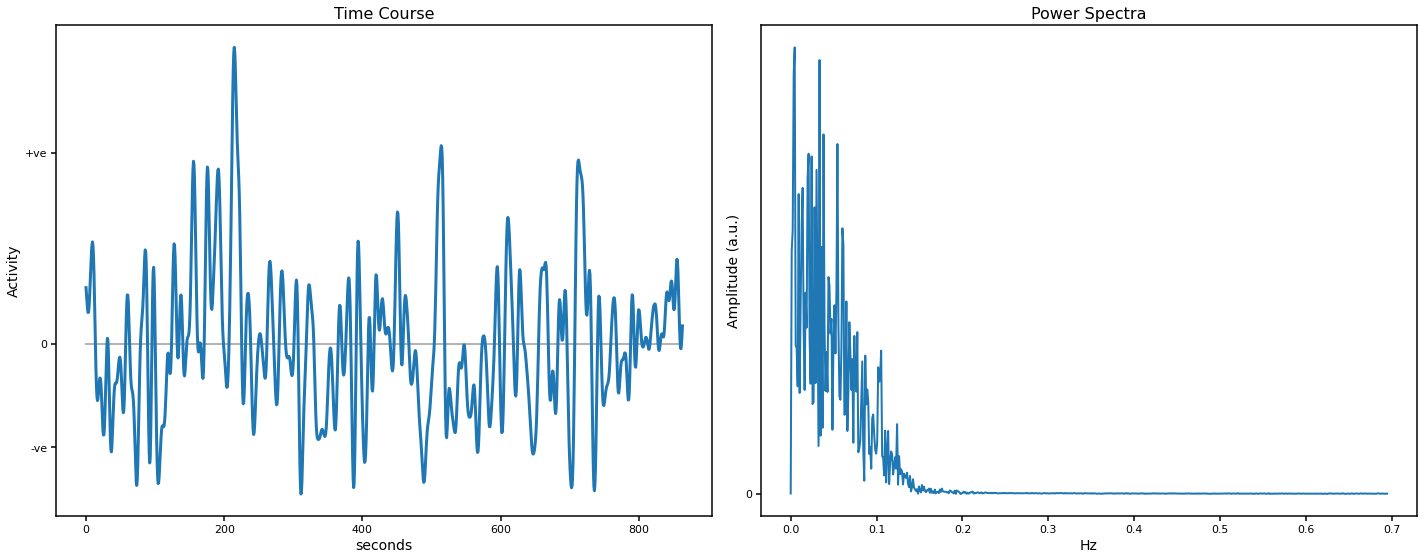

Loading time courses...
Subject 1: subj_0
Subject 2: subj_1
Subject 3: subj_2
Subject 4: subj_3
Done.


                   *** Noise: Default Mode Network, for session R1_LR of subject subj_0: ***


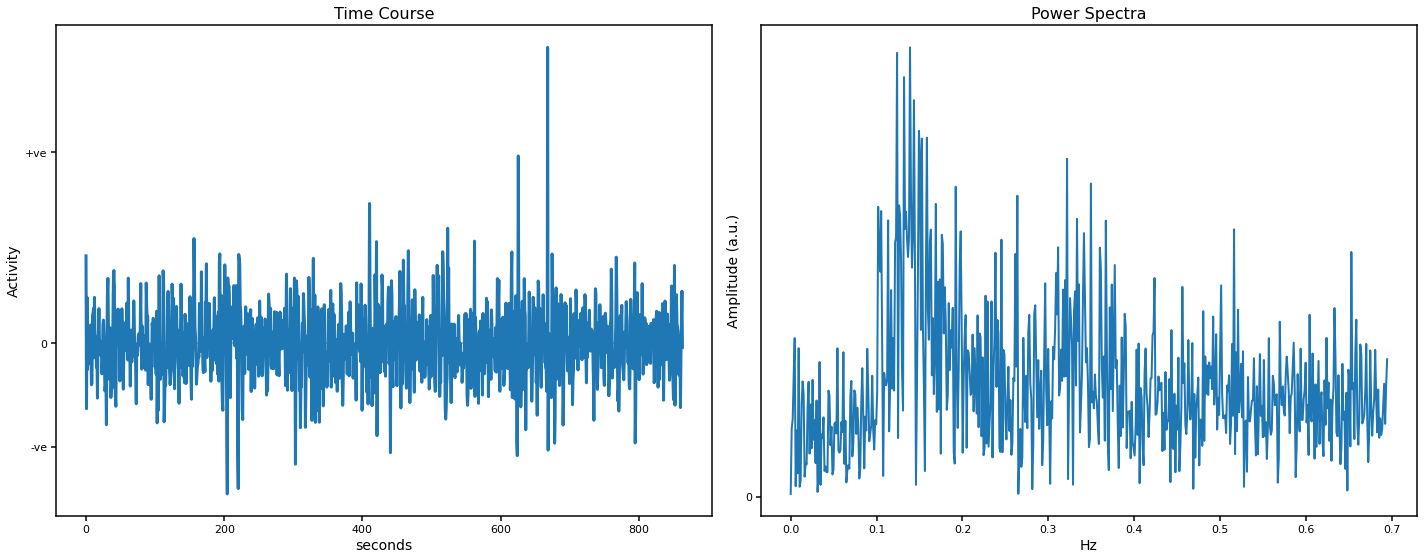

In [12]:
#Executable_cell! 

"""
2.3 SUBJECT-LEVEL TIMECOURSES

PFMs estimate one single set of spatial maps across 4 recording sessions for each subject.
However, the timecourses of each RSN are estimated per subject and session.

Similar to spatial maps, each PFM time course consists of signal and noise elements. The former is typically
used in analyses. Here for educational purposes we examine time courses and power spectra for both signal 
and noise parts for subject subj_0.

"""

#selecting Default Mode Network as the PFM to illustrate:
selected_pfm=copy.deepcopy(pfmorder[40])

#SIGNAL!
#load subject-level PFMs signal for all 4 subjects, this is a python dictionary:
PFM_subjs_signal_timecourse=pfms.load_run_time_courses(clean_time_courses=True)
#select one example subject and session timecourse:
PFM_subj_signal_timecourse=PFM_subjs_signal_timecourse['subj_0']['R1_LR'].copy()

print("\n                   *** Signal: Default Mode Network, for session R1_LR of subject subj_0: ***")
fig,(ax1,ax2)=plt.subplots(1,2); fig.set_size_inches(20, 8, forward=True)
plotting.plot_time_course(fig, ax1, numpy.squeeze(PFM_subj_signal_timecourse[selected_pfm,:]).T, xlabel='seconds', ylabel="Activity",TR=TR), ax1.set_title('Time Course')
plotting.plot_time_course_ffts(fig, ax2,numpy.squeeze(PFM_subj_signal_timecourse[selected_pfm,:])[numpy.newaxis,:],xlabel='Hz',ylabel="Amplitude (a.u.)",TR=TR), ax2.set_title('Power Spectra'); plt.show(block=False)

#NOISE!
#load subject-level PFMs noise for all 4 subjects:
PFM_subjs_signal_timecourse=pfms.load_run_time_courses(only_noise=True)
#select one example subject and session timecourse:
PFM_subj_signal_timecourse=PFM_subjs_signal_timecourse['subj_0']['R1_LR'].copy()

print("\n                   *** Noise: Default Mode Network, for session R1_LR of subject subj_0: ***")
fig,(ax1,ax2)=plt.subplots(1,2); fig.set_size_inches(20, 8, forward=True)
plotting.plot_time_course(fig, ax1, numpy.squeeze(PFM_subj_signal_timecourse[selected_pfm,:]).T, xlabel='seconds', ylabel="Activity",TR=TR), ax1.set_title('Time Course')
plotting.plot_time_course_ffts(fig, ax2,numpy.squeeze(PFM_subj_signal_timecourse[selected_pfm,:])[numpy.newaxis,:],xlabel='Hz',ylabel="Amplitude (a.u.)",TR=TR), ax2.set_title('Power Spectra'); plt.show(block=False)






In [13]:
#Executable_cell! Please press Run and answer the question.
questions.question4()

What is the main diffence between DMN signal and noise timecourses? 
 Press enter to see the answer 
 
The power spectrum of the signal element is restricted to lower frequencies,
whilst background noise is broadband; i.e. includes higher frequencies too. 



                    *** Subject-level Partial temporal correlation (NetMat) between PFMs: *** 



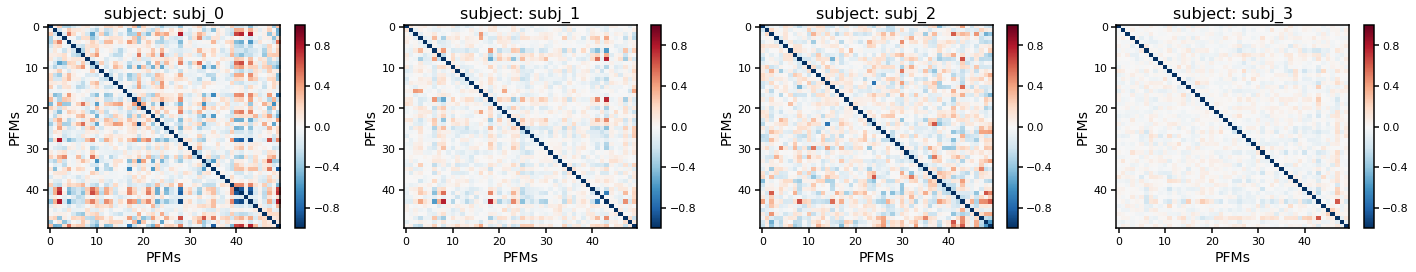

In [14]:
#Executable_cell! 

"""
2.4 SUBJECT-LEVEL TEMPORAL NetMats

Similar to group-level NetMats, and as shown in the model architecture in the beginning,
subject-level NetMats are also estimated hierarchically in PFM framework.
We have estimated one single set of NetMats across 4 recording sessions for each subject.

Here we will load and plot the temporal NetMat for an example subject.

"""

#load subject-level temporal NetMats for all 4 subjects, this is a python dictionary:
precmats=pfms.load_subject_time_course_precmats()
#convert python dictionary to a numpy array
PFM_subj_netmat=numpy.zeros((nsubjs,nmodes,nmodes))
for subi,thissub in enumerate(subject_names):
    precmat=precmats[thissub].copy()
    #the model saves precision matrices, let's convert to partial temporal correlation,
    #and reorder to match group maps in previous sections
    PFM_subj_netmat[subi,:,:]=-utilities.normalise_covmat(precmat)[pfmorder,:][:,pfmorder]


print('                    *** Subject-level Partial temporal correlation (NetMat) between PFMs: *** \n')
# fig,(ax1,ax2,ax3,ax4)=plt.subplots(2,2); 
fig,axes=plt.subplots(1,4);
fig.set_size_inches(20, 4, forward=True)
# print(axes)
for subi,thissub in enumerate(subject_names):
    plotting.plot_matrix(fig,axes[subi],numpy.squeeze(PFM_subj_netmat[subi,:,:]),vmin=-1,vmax=1,cmap='RdBu_r',xlabel='PFMs',ylabel='PFMs',title='subject: '+thissub)
plt.show(block=False)

In [15]:
#Executable_cell! Please press Run and answer the question.
questions.question5()

What is the main diffence between group-level and subject-level PFM NetMats (section 1.6 vs 2.4)? 
 What does this show; discuss implications with your tutor? 
 Press enter to see the answer 
 
Group-level partial temporal NetMats (section 1.6) have much smaller off-diagonal elements.
This shows that even though PFMs at subject-level are temporally correlated with each other,
these correlation patterns may not be consistent across the population for this dataset. 



In [16]:
#Executable_cell! Final question.
questions.final_quiz()


Summarise 5 key features of PFMs that you learned in this practical.
 Send them to your tutor and discuss with them. 
 Press enter. 
 
You have now completed this practical! :-)
